# Tucker Model

In [1]:
# Libraries/packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import optimize

In [2]:
#fix random seed for reproducibility

np.random.seed(seed=42)

### Camp Structure

In [3]:
Nb = 8100          # Number of people in isoboxes.
mub = 10           # Isoboxes mean occupancy (people).
hb = Nb / mub      # Number of isoboxes. 
iba = 0.5          # Proportion of area covered by isoboxes.

Nt = 10600         # Number of people in tents.
mut = 4            # Tents occupancy of (people).
ht = 10600 / mut   # Number of tents.

fblocks = np.array([1,1])   # initial sectoring.
N = Nb + Nt                 # Total population.


### Emperical Age and Sex Distribution

In [4]:
path_to_file = 'age_and_sex.csv'            # Observed data.
age_and_sex = pd.read_csv(path_to_file)     # Data frame. V1 = age, V2 is sex (1 = male?, 0  = female?).
#type(age_and_sex)

# Remove "Unamed column" and preview.
age_and_sex = age_and_sex.loc[:, ~age_and_sex.columns.str.contains('^Unnamed')]
age_and_sex.head() 

,V1,V2
0,2.1,1
1,25.6,0
2,23.6,0
3,49.6,1
4,28.6,0


In [5]:
print(age_and_sex.describe())     # Summary stats.
age_and_sex = age_and_sex.values  # dataframe to 2D array.
#type(age_and_sex)
#age_and_sex[:5,]

                 V1            V2
count  12883.000000  12883.000000
mean      25.615687      0.541877
std       16.570576      0.498263
min        0.100000      0.000000
25%       14.700000      0.000000
50%       24.600000      1.000000
75%       35.100000      1.000000
max       89.700000      1.000000


### Transmission parameters

In [6]:
# Infection
twh = 0.5   # Probability of infecting each person in your household per day.
aip = 0.1   # Probability of infecting each person you meet per meeting (Fang et al.)
tr = 1      # Initial transmission reduction (relative to assumed per contact transmission rate, outside household only).

### Other parameters

In [7]:
siprob = 0        # Probability of spotting symptoms, per person per day.
clearday = 7      # Days in quarantine after no virus shedding (i.e., recovery).
pac = 0.179       # Permanently asymptomatic cases (Mizumoto et al 2020 Eurosurveillance).
ss = 0.20         # Realtive strength of interaction between different ethnicities.

### Initial movement parameters
Note that the initial assumption is that
everyone uses the larger radius some proportion of the time, which is
__NOT__ the same as assuming that some people always use the larger radius,
Nonetheless, I am setting the proportion equal to the number of males age 10-50 in the population.

In [8]:
lr1 = 0.02       # Smaller movement radius
lr2 = 0.1        # Larger movement radius
lrtol = 0.02     # Scale interactions - two people with completely overlapping rages with this radius interact once per day

### Create population matrix (pop)
Columns:
0. Home number
1. Disease state: 0 = susceptible, 1 = exposed, 2 = presymptomatic, 3 = symptomatic, 4 = mild, 5 = severe, 6 = recovered. Similar states in quarentine are the same plus seven.
2. Days to symptoms for this person
3. Days passed in current state
4. Whether this person will be asymptomatic
5. Age
6. Male: = 1 if male.
7. Chronic: = 1 if chronic disease?
8. Wanderer (Uses the larger radius).

pop is $N \times 9$

#### Columns 0-1 (House number and disease state)

- Randomly assign each person to a household (rN).
- Draw a sample from uniform distribution between 1-810 (hb). Meaning we chose a random isobox.
- Then repeat that 8100 (Nb) times. AKA assign each person to an isobox.
- Do the same for the tent group.
- Indices (ui) of the unique array that reconstruct the input array (rN).
- The number of inidces should equal total population (N).
- Start each person as susceptible (col 1 = 0).
- Randomly assign one person to be exposed to the virus (pop[someindex,1]=1).

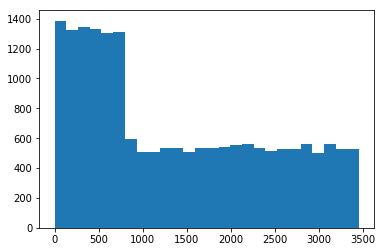

In [9]:
rN = np.concatenate((np.ceil(hb*np.random.uniform(0,1,Nb)), hb+np.ceil(ht*np.random.uniform(0,1,Nt)))) 
# rN = np.concatenate((np.random.choice(np.arange(hb),Nb), hb+np.random.choice(np.arange(ht),Nt))) 
plt.hist(rN,bins='auto')

U,ui = np.unique(rN, return_inverse=True)
assert U[ui].all() == rN.all()

pop_2 = np.column_stack((np.sort(ui), np.zeros((ui.shape)))) # Size N x 2 (18700 x 2).
assert pop_2.shape==(18700, 2)

pop_2[np.random.randint(0,N),1] = 1

#### Columns 2-4 (symptoms)
- Col 2: Days to first symptoms (if they develop symptoms) for each person, following (Backer et al. 2020 Eurosurveillance)
- Col 3: Days passed in current state, 0 for now.
- Col 4: Whether this person will be asymptomatic.

In [10]:
k = (2.3/6.4)**(-1.086)
L = 6.4 / (math.gamma(1 + 1/k))
pop_5 = np.column_stack( (pop_2, k*np.random.weibull(L,(N,1)), np.zeros((N,1)), np.random.uniform(0,1,N)<pac*(N/(N-300))) )
assert pop_5.shape==(18700, 5)

#### Columns 5-6 (Age and sex)
- Get N random samples from the distribution in the observed data with repetition.
- Assign age and sex following the observed distribution in the camp.

I believe I treated the age and sex distributions as separate whereas I think I should treat
the age and sex for a give individual together (if that makes sense?).
i.e. I got the sex and age samples on their own where as the original Matlab code gets them
from the age-sex pairs: age_and_sex(randsample(size(age_and_sex,1),N,true),:)

However, the distributions seem equal in the original program and here.

Billy: I have editted here by drawing samples from rows 

In [11]:
age_and_sex_N=age_and_sex[np.random.randint(age_and_sex.shape[0], size=N), :]

In [12]:
# Is this approach correct?
pop_7 = np.column_stack((pop_5,
                       age_and_sex_N[:,0],
                       age_and_sex_N[:,1]))
assert pop_7.shape==(18700, 7)

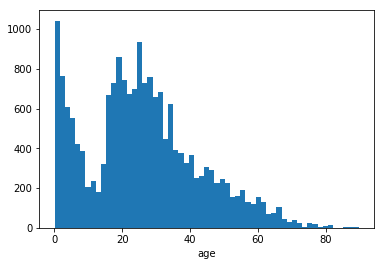

In [13]:
plt.hist(pop_7[:,5],bins='auto')
plt.xlabel('age')
plt.show()

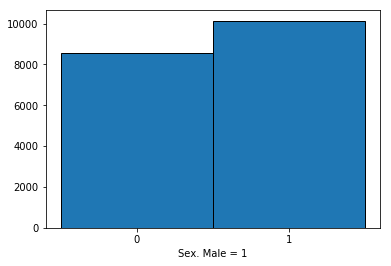

In [14]:
plt.hist(pop_7[:,6], bins=[-0.5,0.5,1.5], ec="k")
plt.xticks((0,1))
plt.xlabel('Sex. Male = 1')
plt.show()

In [15]:
# # Is this approach correct?
# pop = np.column_stack((pop,
#                        np.random.choice(age_and_sex[:,0],N, replace=True),
#                        np.random.choice(age_and_sex[:,1], N, replace=True)))
# # pop.shape

In [16]:
# plt.hist(pop[:,5],bins='auto')
# plt.xlabel('age')
# plt.show()

In [17]:
# plt.hist(pop[:,6], bins=[-0.5,0.5,1.5], ec="k")
# plt.xticks((0,1))
# plt.xlabel('Sex. Male = ?')
# plt.show()

#### Column 7-8 (Chronic States and wanderers)
- Matching the relationship between age and chronic states in the data.
- Males over the age of ten are wanderers.

There is a bug somewhere in the lambda function that makes the minimum (xopt) is too small compared to the original program (~1.62) which causes (rchron) to be 1 for all individuals ... which then makes the asymptomatic column all equal to zero.

Would it be sensible to put an upper limit on the age when defining wanderers? ie. 10 < age < 60

Billy: I am guessing the original equation is trying to find the xopt that makes myfunction-N equals to 0 according to the plot below because otherwise fmin will take the value xopt way to the left. But yeah I am confused in how this equation is produced here - we are aiming to assing 300 people or so with chronic conditions right?

Gonzalo: Fixed. We get ~300 counts.

In [18]:
myfunction = lambda x: np.absolute(300-np.sum((1+np.exp(-(x-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2))**(-1))))-N
xopt = optimize.fsolve(myfunction, x0=[2])
print(xopt)

[1.52000207]


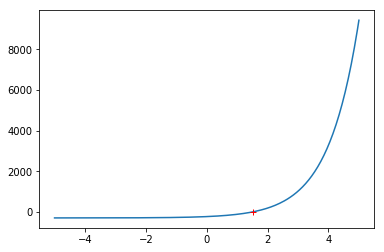

In [19]:
x_s= np.linspace(-5, 5, 201)
y=[myfunction(x) for x in x_s]
plt.plot(x_s, y,xopt,myfunction(xopt),'r+')
plt.show()

In [25]:
#rchron=myfunction(xopt)
rchron = (1+np.exp(-(xopt-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2)))**(-1)
chroncases = (np.random.uniform(np.min(rchron),1,N) < rchron) 

pop_8 = np.column_stack( (pop_7, chroncases))
assert pop_8.shape==(18700, 8)

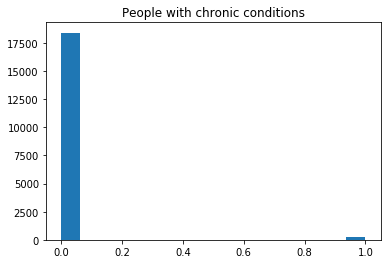

In [27]:
plt.hist(chroncases,bins='auto')
plt.title('Number of People with chronic conditions')
plt.show()

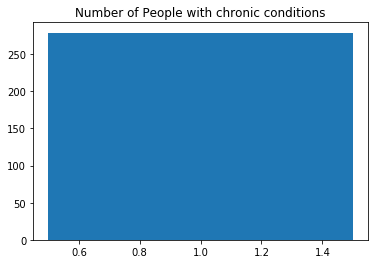

In [31]:
chroncases[np.where(chroncases == 1)]
plt.hist(chroncases[np.where(chroncases == 1)],bins='auto')
plt.title("Number of People with chronic conditions")
plt.show()

In [34]:
# Ensure that people with chronic conditions are not asymptomatic, and correct number of asymptomatics above.
# In other words, if chronic conditions = 1 then not asymptomatic.
pop_8[ pop_8[:,7] == 1,4 ] = 0 
pop_9 = np.column_stack( (pop_8, np.logical_and([pop_8[:,6] == 1], [10 <= pop_8[:,5]]).transpose() ) ) # Wanderers
assert pop_9.shape==(18700, 9)

### Create households
- pph is people per household
- hhloc are the x and y coordinates of each household
- Assign household locations, with isoboxes occupying a square in the center

** maxhh is not equal to ht + hb ? <br>
** Some hhloc formulas just multiply by 1 ?
** Needs fixing. Houses are not properly positioned.

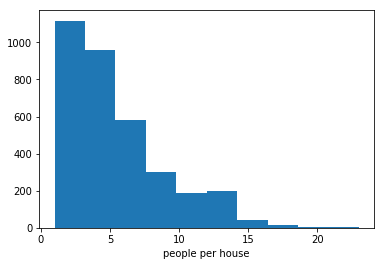

3414
3460.0


In [45]:
pph = np.bincount(ui)
maxhh = pph.size

plt.hist(pph)
plt.xlabel('people per house')
plt.show()


print(maxhh)  # This number is different than total number of house holds
print(ht+hb)

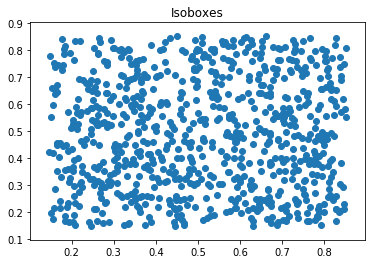

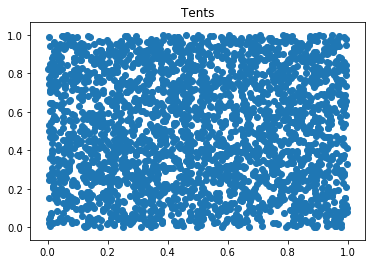

In [66]:
# Assign x and y coordinates to isoboxes (there are hb total isoboxes). 
hhloc1 = 0.5*(1-np.sqrt(iba)) + np.sqrt(iba)*np.random.uniform(0,1,(int(hb),2))
plt.scatter(hhloc1[:,0], hhloc1[:,1])
plt.title('Isoboxes')
plt.show()

# Repeat for tents.
hhloc2 = np.random.uniform(0,1,(int(ht),2))
plt.scatter(hhloc2[:,0], hhloc2[:,1])
plt.title('Tents')
plt.show()

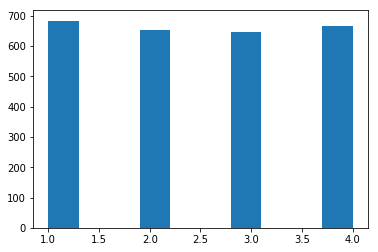

In [64]:
hhloc2w = np.ceil(4*np.random.uniform(0,1,(int(ht),1)))
plt.hist(hhloc2w)
plt.show()

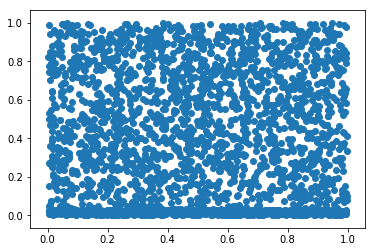

In [88]:
# This block should move some houses to the right edge
# Redo. I didnt do order of operatins right. product then add


scale = 0.5*(1-np.sqrt(iba))
scale

hhloc2[np.where(hhloc2w==1),1] = (1-scale)*hhloc2[np.where(hhloc2w==1),1]
plt.scatter(hhloc2[:,0],hhloc2[:,1])
plt.show()

In [50]:
(1-scale)

0.8535533905932737

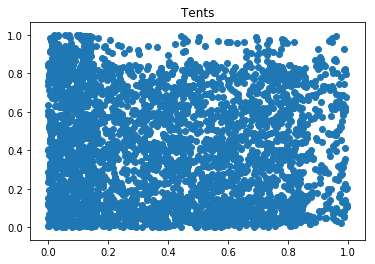

In [47]:
# hhloc2w = np.ceil(4*np.random.uniform(0,1,(int(ht),1)))
scale = 0.5*(1-np.sqrt(iba))

hhloc2[np.where(hhloc2w==1),1] = (1-scale)*hhloc2[np.where(hhloc2w==1),1]
hhloc2[np.where(hhloc2w==3),0] = scale*hhloc2[np.where(hhloc2w==3),0] 
hhloc2[np.where(hhloc2w==4),0] = (1-scale)*hhloc2[np.where(hhloc2w==4),0]
hhloc2[np.where(hhloc2w==4),1] = scale*hhloc2[np.where(hhloc2w==4),1]

# hhloc2[np.where(hhloc2w==2),1] = 0.5*(1+np.sqrt(iba))*hhloc2[np.where(hhloc2w==1),1]
# Original expression does not modify entries. hhloc2(hhloc2w==1,:)=[hhloc2(hhloc2w==1,1)*(1-sqrt(iba))/2+1-(1-sqrt(iba))/2,...
#   hhloc2(hhloc2w==1,2)*(1-(1-sqrt(iba))/2)];

hhloc = np.vstack((hhloc1,hhloc2)) 
plt.scatter(hhloc[:,0], hhloc[:,1])
plt.title('Tents')
plt.show()

### POSITION TOILETS
- Toilets position make an evely spaced $nx \times ny$ grid throughout the camp.

In [ ]:
nx = 12
ny = 12
tblocks = np.array([nx,ny])       # Grid dimensions.
tgroups = tblocks[0]*tblocks[1]   # Number of blocks in the grid.
tu = N/tgroups                    # ~ people / toilet

tgrid1 = np.sum(np.outer(hhloc[:,0],np.ones((1,tblocks[0])))>np.outer(np.ones((int(hb+ht),1)), np.arange(1, tblocks[0]+1)/tblocks[0]),1)
tgrid2 = np.sum(np.outer(hhloc[:,1],np.ones((1,tblocks[1])))>np.outer(np.ones((int(hb+ht),1)), np.arange(1, tblocks[1]+1)/tblocks[1]),1)
tnum = tgrid2*tblocks[0]+tgrid1+1


In [ ]:
# %Create where 1 indicates that households share the same toilet
# tshared=(tnum*ones(size(tnum))'==ones(size(tnum))*tnum')-eye(maxhh);

### Create ethnic groups

In [ ]:
#  Ethnic groups are spatailly clustered and randomly
# %positioned. Households are assigned to ethnicities. The distribution
# %matches the distribution of people in the Moria data. Only ethnicites
# %with >50 people in the observed data included.
# g=[7919,149,706,107,83,442,729];    %[Afghan,Cameroon,Congo,Iran,Iraq,Somalia,Syria]
# g=round(maxhh*g/15327);             %number of household per group
# g=datasample(g,length(g),'Replace',false);  %randomise group order